In [76]:
pip install geocoder

Note: you may need to restart the kernel to use updated packages.


In [77]:
#install necessary Libraries 
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import requests
from bs4 import BeautifulSoup
import geocoder
import os
import folium # map rendering library
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline


print('Libraries imported.')

Libraries imported.


In [78]:
#Function to get latitude and longitude of a given location using geopy
def geo_location(address):
    # get geo location of address
    geolocator = Nominatim(user_agent="ny_explorer")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude

In [79]:
#function to return us the venue id , venue name and category
def get_venues(lat,lng):
    
    #set variables
    radius=1000
    LIMIT=100
    CLIENT_ID ='0ZSLIA5QAODYDMLANUDACZYEUJE2JISCGNU41ELUQSUX0APW' # your Foursquare ID
    CLIENT_SECRET ='R0QKBAJYQOGPHWSCUBWCC54H40F0NFFKXA1MX5OBRPTUZXHW' # your Foursquare Secret
    VERSION ='20200419' # Foursquare API version
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results["response"]['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
        
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

In [80]:
#function to get venue details like like count , rating , tip counts for a given venue id

def get_venue_details(venue_id):
        
    CLIENT_ID ='0ZSLIA5QAODYDMLANUDACZYEUJE2JISCGNU41ELUQSUX0APW' # your Foursquare ID
    CLIENT_SECRET ='R0QKBAJYQOGPHWSCUBWCC54H40F0NFFKXA1MX5OBRPTUZXHW' # your Foursquare Secret
    VERSION ='20200419' # Foursquare API version
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
        
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

In [81]:
#funtion to get the new york city data such as Boroughs, Neighborhoods along with their latitude and longitude

def get_new_york_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    # all data is present in features label
    features=resp['features']
    
    # define the dataframe columns
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    # instantiate the dataframe
    new_york_data = pd.DataFrame(columns=column_names)
    
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
    
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    
    return new_york_data

In [82]:

# get new york data
new_york_data=get_new_york_data()

In [83]:
new_york_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [84]:
new_york_data.shape

(306, 4)

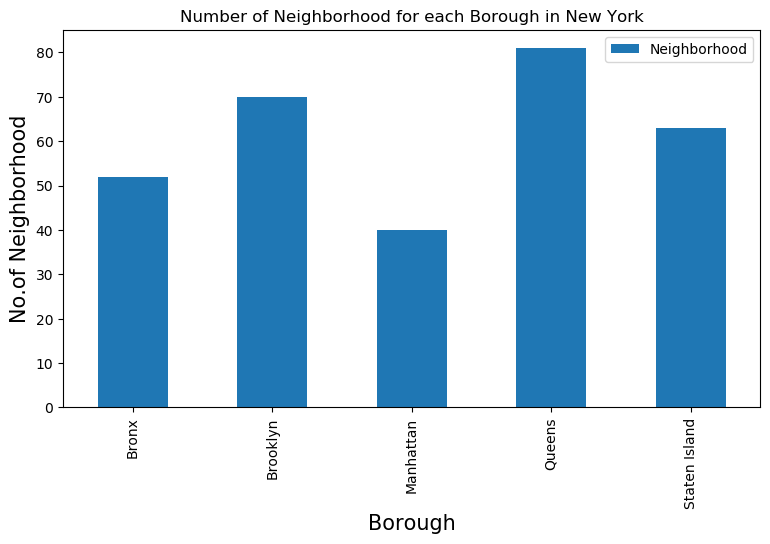

In [85]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Neighborhood for each Borough in New York')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Neighborhood', fontsize=15)
#giving a bar plot
new_york_data.groupby('Borough')['Neighborhood'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

In [86]:
# prepare neighborhood list that contains indian resturants
column_names=['Borough', 'Neighborhood', 'ID','Name']
indian_rest_ny=pd.DataFrame(columns=column_names)
count=1
for row in new_york_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    indian_resturants=venues[venues['Category']=='Indian Restaurant']   
    print('(',count,'/',len(new_york_data),')','Indian Resturants in '+Neighborhood+', '+Borough+':'+str(len(indian_resturants)))
    for resturant_detail in indian_resturants.values.tolist():
        id, name , category=resturant_detail
        indian_rest_ny = indian_rest_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

( 1 / 306 ) Indian Resturants in Wakefield, Bronx:0
( 2 / 306 ) Indian Resturants in Co-op City, Bronx:0
( 3 / 306 ) Indian Resturants in Eastchester, Bronx:0
( 4 / 306 ) Indian Resturants in Fieldston, Bronx:0
( 5 / 306 ) Indian Resturants in Riverdale, Bronx:0
( 6 / 306 ) Indian Resturants in Kingsbridge, Bronx:0
( 7 / 306 ) Indian Resturants in Marble Hill, Manhattan:0
( 8 / 306 ) Indian Resturants in Woodlawn, Bronx:1
( 9 / 306 ) Indian Resturants in Norwood, Bronx:0
( 10 / 306 ) Indian Resturants in Williamsbridge, Bronx:0
( 11 / 306 ) Indian Resturants in Baychester, Bronx:0
( 12 / 306 ) Indian Resturants in Pelham Parkway, Bronx:0
( 13 / 306 ) Indian Resturants in City Island, Bronx:0
( 14 / 306 ) Indian Resturants in Bedford Park, Bronx:0
( 15 / 306 ) Indian Resturants in University Heights, Bronx:0
( 16 / 306 ) Indian Resturants in Morris Heights, Bronx:0
( 17 / 306 ) Indian Resturants in Fordham, Bronx:0
( 18 / 306 ) Indian Resturants in East Tremont, Bronx:0
( 19 / 306 ) Ind

( 143 / 306 ) Indian Resturants in Maspeth, Queens:0
( 144 / 306 ) Indian Resturants in Ridgewood, Queens:1
( 145 / 306 ) Indian Resturants in Glendale, Queens:0
( 146 / 306 ) Indian Resturants in Rego Park, Queens:1
( 147 / 306 ) Indian Resturants in Woodhaven, Queens:0
( 148 / 306 ) Indian Resturants in Ozone Park, Queens:0
( 149 / 306 ) Indian Resturants in South Ozone Park, Queens:1
( 150 / 306 ) Indian Resturants in College Point, Queens:0
( 151 / 306 ) Indian Resturants in Whitestone, Queens:0
( 152 / 306 ) Indian Resturants in Bayside, Queens:3
( 153 / 306 ) Indian Resturants in Auburndale, Queens:0
( 154 / 306 ) Indian Resturants in Little Neck, Queens:0
( 155 / 306 ) Indian Resturants in Douglaston, Queens:0
( 156 / 306 ) Indian Resturants in Glen Oaks, Queens:4
( 157 / 306 ) Indian Resturants in Bellerose, Queens:0
( 158 / 306 ) Indian Resturants in Kew Gardens Hills, Queens:0
( 159 / 306 ) Indian Resturants in Fresh Meadows, Queens:0
( 160 / 306 ) Indian Resturants in Briarw

( 280 / 306 ) Indian Resturants in Fulton Ferry, Brooklyn:0
( 281 / 306 ) Indian Resturants in Vinegar Hill, Brooklyn:0
( 282 / 306 ) Indian Resturants in Weeksville, Brooklyn:0
( 283 / 306 ) Indian Resturants in Broadway Junction, Brooklyn:1
( 284 / 306 ) Indian Resturants in Dumbo, Brooklyn:0
( 285 / 306 ) Indian Resturants in Manor Heights, Staten Island:0
( 286 / 306 ) Indian Resturants in Willowbrook, Staten Island:0
( 287 / 306 ) Indian Resturants in Sandy Ground, Staten Island:0
( 288 / 306 ) Indian Resturants in Egbertville, Staten Island:0
( 289 / 306 ) Indian Resturants in Roxbury, Queens:0
( 290 / 306 ) Indian Resturants in Homecrest, Brooklyn:0
( 291 / 306 ) Indian Resturants in Middle Village, Queens:0
( 292 / 306 ) Indian Resturants in Prince's Bay, Staten Island:0
( 293 / 306 ) Indian Resturants in Lighthouse Hill, Staten Island:0
( 294 / 306 ) Indian Resturants in Richmond Valley, Staten Island:0
( 295 / 306 ) Indian Resturants in Malba, Queens:0
( 296 / 306 ) Indian Re

In [87]:
indian_rest_ny.head()

,Borough,Neighborhood,ID,Name
0,Bronx,Woodlawn,4c0448d9310fc9b6bf1dc761,Curry Spot
1,Bronx,Parkchester,4c194631838020a13e78e561,Melanies Roti Bar And Grill
2,Bronx,Spuyten Duyvil,4c04544df423a593ac83d116,Cumin Indian Cuisine
3,Bronx,Concourse,551b7f75498e86c00a0ed2e1,Hungry Bird
4,Bronx,Unionport,4c194631838020a13e78e561,Melanies Roti Bar And Grill


In [88]:
indian_rest_ny.shape

(137, 4)

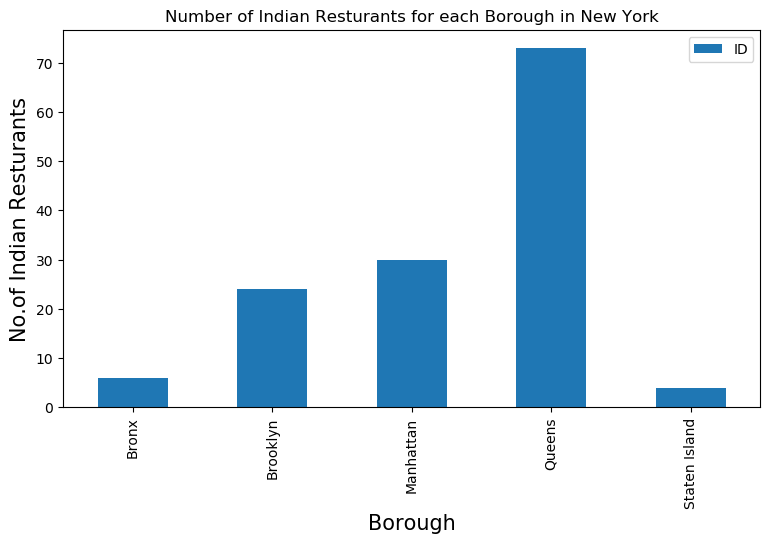

In [90]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Indian Resturants for each Borough in New York')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Indian Resturants', fontsize=15)
#giving a bar plot
indian_rest_ny.groupby('Borough')['ID'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

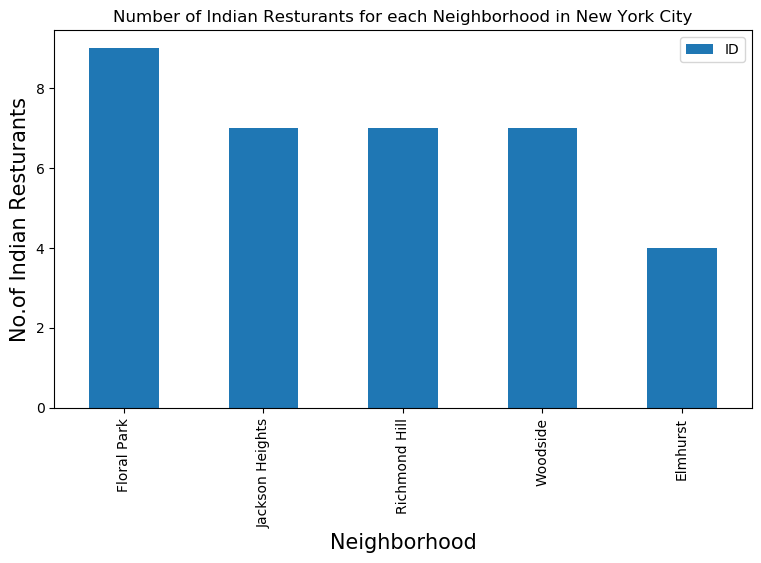

In [91]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Indian Resturants for each Neighborhood in New York City')
#On x-axis
plt.xlabel('Neighborhood', fontsize = 15)
#On y-axis
plt.ylabel('No.of Indian Resturants', fontsize=15)
#giving a bar plot
indian_rest_ny.groupby('Neighborhood')['ID'].count().nlargest(5).plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

In [92]:
indian_rest_ny[indian_rest_ny['Neighborhood']=='Floral Park']

,Borough,Neighborhood,ID,Name
96,Queens,Floral Park,527ffc0811d2d329d5e49abd,Jackson Diner
97,Queens,Floral Park,4e4e3e22bd4101d0d7a5c2d1,Kerala Kitchen
98,Queens,Floral Park,4b647b56f964a520c4b62ae3,Usha Foods & Usha Sweets
99,Queens,Floral Park,4b787c49f964a5209cd12ee3,Santoor Indian Restaurant
100,Queens,Floral Park,4c0c01e0bbc676b00d6b4cd5,Mumbai Xpress
101,Queens,Floral Park,4c76ff35a5676dcb72671721,Flavor Of India
102,Queens,Floral Park,4df0f39dd4c04d0392c853ea,Sagar Chinese
103,Queens,Floral Park,4c953a7672dd224bd8d1a191,Real Usha Sweets & Snacks Inc.
104,Queens,Floral Park,4e6bfe1c7d8b2c711b17bbe5,Surya sweets and snacks


In [93]:
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
indian_rest_stats_ny=pd.DataFrame(columns=column_names)
count=1


for row in indian_rest_ny.values.tolist():
    Borough,Neighborhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID)
        # we will assign 0 value for these resturants as they may have been 
        #recently opened or details does not exist in FourSquare Database
        id,name,likes,rating,tips=[0]*5
    print('(',count,'/',len(indian_rest_ny),')','processed')
    indian_rest_stats_ny = indian_rest_stats_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1

                         ID        Name  Likes  Rating  Tips
0  4c0448d9310fc9b6bf1dc761  Curry Spot      5     8.0    10
( 1 / 137 ) processed
                         ID                         Name  Likes  Rating  Tips
0  4c194631838020a13e78e561  Melanies Roti Bar And Grill      3     6.3     2
( 2 / 137 ) processed
                         ID                  Name  Likes  Rating  Tips
0  4c04544df423a593ac83d116  Cumin Indian Cuisine     13     5.9     9
( 3 / 137 ) processed
                         ID         Name  Likes  Rating  Tips
0  551b7f75498e86c00a0ed2e1  Hungry Bird      8     6.7     3
( 4 / 137 ) processed
                         ID                         Name  Likes  Rating  Tips
0  4c194631838020a13e78e561  Melanies Roti Bar And Grill      3     6.3     2
( 5 / 137 ) processed
                         ID       Name  Likes  Rating  Tips
0  4b5a4dc8f964a520a2bb28e3  Taj Mahal     38     8.3    26
( 6 / 137 ) processed
                         ID          Name  Likes

KeyError: 'venue'

In [94]:
indian_rest_stats_ny.head()

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Bronx,Woodlawn,4c0448d9310fc9b6bf1dc761,Curry Spot,5,8.0,10
1,Bronx,Parkchester,4c194631838020a13e78e561,Melanies Roti Bar And Grill,3,6.3,2
2,Bronx,Spuyten Duyvil,4c04544df423a593ac83d116,Cumin Indian Cuisine,13,5.9,9
3,Bronx,Concourse,551b7f75498e86c00a0ed2e1,Hungry Bird,8,6.7,3
4,Bronx,Unionport,4c194631838020a13e78e561,Melanies Roti Bar And Grill,3,6.3,2


In [95]:
indian_rest_stats_ny.shape

(50, 7)

In [96]:
indian_rest_ny.shape

(137, 4)

In [97]:
indian_rest_stats_ny.to_csv('indian_rest_stats_ny.csv', index=False)

In [98]:
indian_rest_stats_ny_csv=pd.read_csv('indian_rest_stats_ny.csv')

In [99]:
indian_rest_stats_ny_csv.shape

(50, 7)

In [100]:
indian_rest_stats_ny_csv.head()

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Bronx,Woodlawn,4c0448d9310fc9b6bf1dc761,Curry Spot,5,8.0,10
1,Bronx,Parkchester,4c194631838020a13e78e561,Melanies Roti Bar And Grill,3,6.3,2
2,Bronx,Spuyten Duyvil,4c04544df423a593ac83d116,Cumin Indian Cuisine,13,5.9,9
3,Bronx,Concourse,551b7f75498e86c00a0ed2e1,Hungry Bird,8,6.7,3
4,Bronx,Unionport,4c194631838020a13e78e561,Melanies Roti Bar And Grill,3,6.3,2


In [101]:
indian_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 7 columns):
Borough         50 non-null object
Neighborhood    50 non-null object
ID              50 non-null object
Name            50 non-null object
Likes           50 non-null object
Rating          50 non-null float64
Tips            50 non-null object
dtypes: float64(1), object(6)
memory usage: 2.9+ KB


In [102]:
indian_rest_stats_ny['Likes']=indian_rest_stats_ny['Likes'].astype('float64')

In [103]:

indian_rest_stats_ny['Tips']=indian_rest_stats_ny['Tips'].astype('float64')

In [104]:
indian_rest_stats_ny.iloc[indian_rest_stats_ny['Likes'].idxmax()]

Borough                        Manhattan
Neighborhood                     Tribeca
ID              4bbb9dbded7776b0e1ad3e51
Name                    Tamarind TriBeCa
Likes                                590
Rating                               9.1
Tips                                 148
Name: 37, dtype: object

In [105]:
indian_rest_stats_ny.iloc[indian_rest_stats_ny['Rating'].idxmax()]

Borough                        Manhattan
Neighborhood                     Tribeca
ID              4bbb9dbded7776b0e1ad3e51
Name                    Tamarind TriBeCa
Likes                                590
Rating                               9.1
Tips                                 148
Name: 37, dtype: object

In [106]:
indian_rest_stats_ny.iloc[indian_rest_stats_ny['Tips'].idxmax()]

Borough                        Manhattan
Neighborhood                    Gramercy
ID              4a12eb1ff964a52099771fe3
Name                               Dhaba
Likes                                497
Rating                               8.4
Tips                                 164
Name: 45, dtype: object

In [107]:
ny_neighborhood_stats=indian_rest_stats_ny.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating']]
ny_neighborhood_stats.columns=['Neighborhood','Average Rating']

In [108]:
ny_neighborhood_stats.sort_values(['Average Rating'],ascending=False).head(10)

,Neighborhood,Average Rating
28,Tribeca,9.100
0,Astoria,8.850
22,Prospect Heights,8.800
19,Murray Hill,8.800
31,West Village,8.700
5,Clinton Hill,8.700
11,Fort Greene,8.700
9,East Village,8.600
26,South Side,8.500
13,Gramercy,8.475


In [109]:
ny_borough_stats=indian_rest_stats_ny.groupby('Borough',as_index=False).mean()[['Borough','Rating']]
ny_borough_stats.columns=['Borough','Average Rating']

In [110]:
ny_borough_stats.sort_values(['Average Rating'],ascending=False).head()

,Borough,Average Rating
3,Queens,8.70000
2,Manhattan,8.13913
1,Brooklyn,7.40000
0,Bronx,6.64000


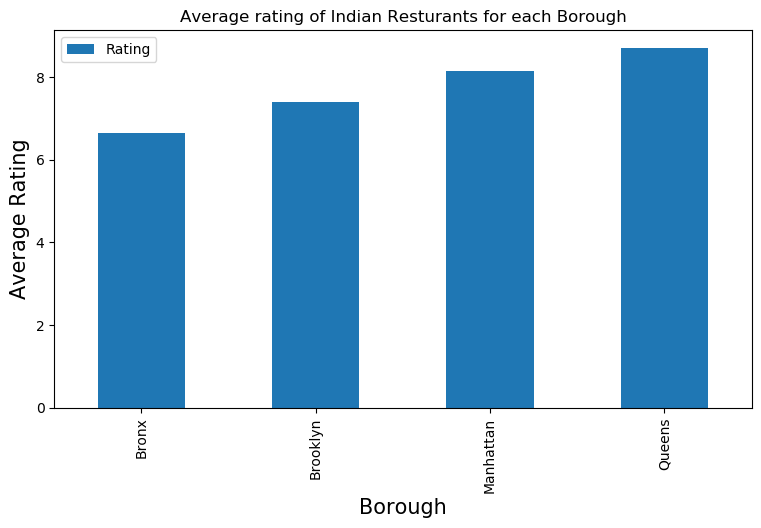

In [57]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Average rating of Indian Resturants for each Borough')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('Average Rating', fontsize=15)
#giving a bar plot
indian_rest_stats_ny.groupby('Borough').mean()['Rating'].plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

In [111]:
#We will consider all the neighborhoods with average rating greater or equal 9.0 to visualize on ma
ny_neighborhood_stats=ny_neighborhood_stats[ny_neighborhood_stats['Average Rating']>=9.0]

In [112]:
ny_neighborhood_stats

,Neighborhood,Average Rating
28,Tribeca,9.1


In [114]:
ny_neighborhood_stats=pd.merge(ny_neighborhood_stats,new_york_data, on='Neighborhood')

In [116]:
ny_neighborhood_stats=ny_neighborhood_stats[['Borough','Neighborhood','Latitude','Longitude','Average Rating']]

KeyError: "['Longitude', 'Borough', 'Latitude'] not in index"